# Loading in Concave Pit Data

## 1. Data Types

Height data in this project comes in two formats, each with pros and cons. This will ingest both types and output a single format type for both.

### Type 1. Keyence ASCII Raster

This dataset includes several lines of metadata and comma separated lists of height data, representing a raster dataset

**Pros:** 
* Clear Metadata
* Grid positions (row, col) of datapoints are obvious

**Cons:**
* X-Y positions need to be computed

### Type 2. Coordinate Triplet List

This dataset includes lines of 3 values, which are x, y, and z coordinates

**Pros:** 
* X, Y positions are given

**Cons:**
* No in-file Metadata
* Grid positions (row, col) are not obvious


## 2. Load Keyence Data, view it, and export it

### First we open the file and extract key metadata

Because Keyence data surrounds all values with quotes, which doesn't work well with numpy, we will first pass it through a search and replace command. 

Then the resulting temporary file will be opened to help gather data.

In [1]:
keyfile = 'data/FC3_Pit17_meas_corr_height-skip1.csv'

tempfile = 'data/temp.dat'

### make a temporary replacement file with no quotations
with open( keyfile, "r" ) as source:
    with open( tempfile, "w" ) as target:
        data = source.read()
        changed = data.replace('"','')
        target.write( changed )

### read the temporary file for metadata
with open(tempfile) as kf:
    line = kf.readline()#.strip()
    count = 1
    while line:
        linestr = line.split(',')
        metadata_field = linestr[0]
        if metadata_field == 'XY calibration':
            xy_res      = float(linestr[1])
            xy_res_unit = linestr[2]
            print('xy resolution: %0.3f %s' % (xy_res, xy_res_unit))
        elif metadata_field == 'Z calibration':
            z_res      = float(linestr[1])
            z_res_unit = linestr[2]
            print('z resolution: %0.3f %s' % (z_res, z_res_unit))
        elif metadata_field == 'Width':
            array_size_line = kf.readline().split(',')
            cols = int(array_size_line[0])
            rows = int(array_size_line[1])
            print('Raster has dimensions: %d lines by %d pixels' % (rows,cols))
            
        count += 1
        line = kf.readline()#.strip()

header_lines = count - rows
print('The entire file has %d lines, %d of which are header lines' % (count,header_lines))

xy resolution: 694.430 nm/pixel

z resolution: 0.100 nm/digit

Raster has dimensions: 768 lines by 1024 pixels
The entire file has 820 lines, 52 of which are header lines


### Now that we know the size and scale of the data, we can view and evaluate the data

In [2]:
# Import the actual data
import numpy as np
import os

try: 
    z_data = np.loadtxt(tempfile,skiprows=header_lines,delimiter=',')
    print('The shape of the height data is: ',z_data.shape)

    # Now that data is loaded, scrap the temp file. You won't miss it.
    os.remove(tempfile)
except OSError:
    print('No temp file. - Run the above line again to regenerate it.')

The shape of the height data is:  (768, 1024)


If we assume the resolution units are based in nm (see above), then we can use the resolution values to convert from integer values to SI units.

In [3]:
#Convert height values from nm to um

z_res *= 0.001
#z resolution is now in um
#Assumes z_res value is in nm/digit

#This flips the array so that the top line corresponds to the max y value
z_data = z_data[::-1] 

ZZ = z_res * z_data
#ZZ is z_data but now in um

print('The height range is %0.6f - %0.6f microns' % (np.min(ZZ),np.max(ZZ)))

#Get the grid cell coordinates as well

xy_res *= 0.001
#x,y resoultion now in um
#Assumes xy_res value is in nm/pixel

Xs = np.arange(cols) * xy_res #This is a list of all unique X coordinates in the grid
Ys = np.arange(rows) * xy_res #This is a list of all unique Y coordinates in the grid
XX,YY = np.meshgrid(Xs,Ys)    #This makes a grid of all X,Y coordinate points

The height range is 0.000000 - 355.420300 microns


**We can visualize this raster image using the imshow method**

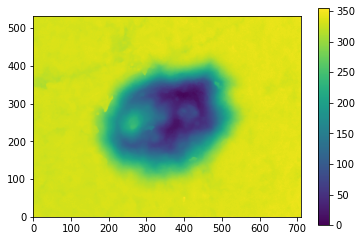

In [4]:
import matplotlib.pyplot as plt

map_extent = [np.min(Xs),np.max(Xs),np.min(Ys),np.max(Ys)]
plt.imshow(ZZ,extent=map_extent)
plt.colorbar()
plt.show()

*N.B. 300 um is 0.3 mm*

### Exporting the Data as a CSV with some lines of metadata

This data will be exported to a csv file of coordinate triplets that includes commented header lines to preserve some information

In [5]:
export_filename = 'data/FC3_P17_keyence.csv'

#Flatten the array data for export (we want a list, not another grid!)
XXexport = XX.flatten()
YYexport = YY.flatten()
ZZexport = ZZ.flatten()

with open(export_filename, 'w') as ef:
    ef.write('# Produced from Keyence Raster: %s\n' % keyfile)
    ef.write('# Units: um\n')
    ef.write('# x interval: %0.6f\n' % xy_res)
    ef.write('# y interval: %0.6f\n' % xy_res)
    ef.write('# rows: %d\n' % rows)
    ef.write('# columns: %d\n' % cols)
    ef.write('# vertical resolution: %0.6f\n' % z_res)
    ef.write('# \n# x, y, z\n')
    
    #Now export the data!
    for i in range(len(ZZexport)):
        ef.write('%0.8f,%0.8f,%0.8f\n' % (XXexport[i],YYexport[i],ZZexport[i]))
        
#Here's an example of what the data look like:
print('Example output:')
for i in range(10):
    print('%0.8f,%0.8f,%0.8f' % (XXexport[i],YYexport[i],ZZexport[i]))
    
    

Example output:
0.00000000,0.00000000,333.84740000
0.69443000,0.00000000,334.83700000
1.38886000,0.00000000,334.04160000
2.08329000,0.00000000,335.46120000
2.77772000,0.00000000,333.60090000
3.47215000,0.00000000,334.36550000
4.16658000,0.00000000,335.83510000
4.86101000,0.00000000,335.73480000
5.55544000,0.00000000,335.77940000
6.24987000,0.00000000,333.73400000


### Keyence Summary
1. Keyence ascii raster metadata was found using the file header lines
2. Raster height data was read into an array, *z_data*
3. X,Y coordinates were calculated for every grid position
4. All data was converted to microns from nm
5. The raster data was visualized with imgsrc
6. The raster data was exported as a list of x,y,z coordinate triplets

## 3. Load CSV List Data, view it, and export it

The second data type is a list of measurements with x,y,z coordinate triplets. We can load this in and deduce the grid spacing from the x and y values.

In [6]:
csvfile = 'data/FC3Pit17S0.5mmX0.5mmRaw.csv'

csv_data = np.loadtxt(csvfile,delimiter=',')

#print the first 10 records
print('The first 10 records look like:')
print(csv_data[0:10])

x_data = csv_data[:,0]
y_data = csv_data[:,1]
z_data = csv_data[:,2]

print('')
print('In total, there are %d coordinates' % len(csv_data))
print('The x and y data ranges are: (%0.6f, %0.6f), (%0.6f, %0.6f)' % (np.min(x_data),np.max(x_data),np.min(y_data),np.max(y_data)))
print('The z data range is: (%0.6f, %0.6f)' % (np.min(z_data),np.max(z_data)))
print('90%% of the heights are between %0.6f and %0.6f' % (np.percentile(z_data,5),np.percentile(z_data,95)))

The first 10 records look like:
[[5.9    5.76   5.9647]
 [5.905  5.76   5.9725]
 [5.91   5.76   5.9639]
 [5.915  5.76   5.9294]
 [5.92   5.76   5.9349]
 [5.925  5.76   5.9297]
 [5.93   5.76   5.9056]
 [5.935  5.76   5.9018]
 [5.94   5.76   5.9007]
 [5.9451 5.76   5.9128]]

In total, there are 10000 coordinates
The x and y data ranges are: (5.900000, 6.396300), (5.760000, 6.253500)
The z data range is: (1.664000, 6.100200)
90% of the heights are between 5.671700 and 6.021200


### Visualize the CSV data

The grid spacing for this incoming pit data is not yet known but it will be derived below. First, let's visualize the data using a scatter plot.

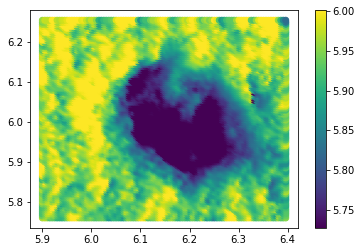

In [7]:
#csv_data = csv_data[np.where(csv_data[:,2]<7.08)]

lx_data = csv_data[:,0]
ly_data = csv_data[:,1]
lz_data = csv_data[:,2]

plt.clf()
msize = csv_data[:,2]*-1 + 8
plt.scatter(lx_data,ly_data,c=lz_data)
plt.clim([np.percentile(lz_data,10),np.percentile(lz_data,90)])
plt.colorbar()
plt.show()

### Deduce Grid Spacing and Reshape the Data

The number of rows and columns will be important in deriving pit location and calculating volume in future steps. Here we make an attempt to find row and column spacing. There are a few workflows that can perform this. None are perfect for data that is imperfectly gridded, so visual confirmation is important.

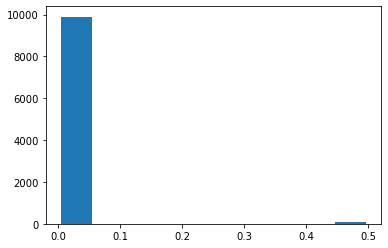

In [8]:
#calculate the difference between x[i] and x[i-1]. 
#The number should usually be small... except at new lines!
x_diff = np.zeros(len(lx_data)-1)
for i,x in enumerate(lx_data):
    if i>0:
        x_diff[i-1] = abs(lx_data[i] - lx_data[i-1])

plt.clf()
plt.hist(x_diff)
plt.show()

In the above histogram, virtually all of the dx values are <0.2, which corresponds to the low dx interval in each grid row. A small number of dx values are higher, about the difference of the max x value and the min x value. Counting them will produce an estimate of the number of rows.

In [9]:
#How many dx are above 0.2? This is how many 'new rows' are in the dataset
#The first row isn't counted here, so we add 1 to the solution
rowCt = len(np.where(x_diff > 0.2)[0]) + 1

print('This dataset has %d coordinates' % len(lx_data))

print('This dataset has %0.6f rows.' % rowCt)

colCt = len(lx_data) / rowCt
print('This dataset has %0.6f columns.' % colCt)

xRes = (np.max(lx_data) - np.min(lx_data))/colCt
yRes = (np.max(ly_data) - np.min(ly_data))/rowCt

print('The average x interval is: %0.6f' % xRes)
print('The average y interval is: %0.6f' % yRes)

This dataset has 10000 coordinates
This dataset has 100.000000 rows.
This dataset has 100.000000 columns.
The average x interval is: 0.004963
The average y interval is: 0.004935


*N.B. One way to tell that this is an incorrect solution is if the final row and column count are not integers.*

The dataset can be reshaped and viewed as a raster to compare to the scatter plot above. It should be essentially identical; a shearing pattern would suggest an incorrect row/column solution.

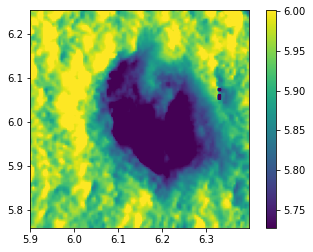

In [10]:
#reshape the data from a list to a row x column array
#the [::-1] reverses the array, so the first line is the highest line
lZZ = lz_data.reshape(int(rowCt),int(colCt))[::-1]

#illustrate it as a raster with imshow
lmap_extent = [np.min(lx_data),np.max(lx_data),np.min(ly_data),np.max(ly_data)]
plt.clf()
plt.imshow(lZZ,extent=lmap_extent)
plt.clim([np.percentile(lz_data,10),np.percentile(lz_data,90)])
plt.colorbar()
plt.show()

### Export the Data in a Standard Format

While this data is already packaged in a CSV file, it can be re-exported with some metadata for future readers to gain information about the dataset.

First we will convert the data into microns, as we did to the Keyence data above.

In [11]:
#This assumes the data is in mm and is being converted to um
lx_data *= 1000.0
ly_data *= 1000.0
lz_data *= 1000.0
xRes *= 1000.0
yRes *= 1000.0

lunits = 'um'

Then we export the data to a csv file. This is very similar to the final code from the previous section on Keyence data, and a savvy programmer would make it into a pre-defined function at the top of a python script.

In [12]:
listExportFilename = 'data/FC3_P17_neptec_0-5mm.csv'

#From visual inspection the zRes from this data looks to be 0.1 um.
#Perhaps autocheck for this in the future
zRes = 0.1

with open(listExportFilename, 'w') as ef:
    ef.write('# Produced from Neptec List: %s\n' % csvfile)
    ef.write('# Units: %s\n' % lunits)
    ef.write('# x interval: %0.6f\n' % xRes)
    ef.write('# y interval: %0.6f\n' % yRes)
    ef.write('# rows: %d\n' % rowCt)
    ef.write('# columns: %d\n' % colCt)
    ef.write('# vertical resolution: %0.6f\n' % zRes)
    ef.write('# \n# x, y, z\n')
    
    #Now export the data!
    for i in range(len(lz_data)):
        ef.write('%0.8f,%0.8f,%0.8f\n' % (lx_data[i],ly_data[i],lz_data[i]))
        
#Here's an example of what the data look like:
print('Example output:')
for i in range(10):
    print('%0.8f,%0.8f,%0.8f' % (lx_data[i],ly_data[i],lz_data[i]))
    

Example output:
5900.00000000,5760.00000000,5964.70000000
5905.00000000,5760.00000000,5972.50000000
5910.00000000,5760.00000000,5963.90000000
5915.00000000,5760.00000000,5929.40000000
5920.00000000,5760.00000000,5934.90000000
5925.00000000,5760.00000000,5929.70000000
5930.00000000,5760.00000000,5905.60000000
5935.00000000,5760.00000000,5901.80000000
5940.00000000,5760.00000000,5900.70000000
5945.10000000,5760.00000000,5912.80000000


### CSV Summary
1. Ascii csv data was read and assigned to three arrays: `lx_data`, `ly_data`, and `lz_data` 
2. The list data was visualized with scatter
3. Grid metadata was derived using intervals between successive `lx_data` entries
4. The raster data was visualized with imgsrc
5. All data was converted to microns from mm
6. The raster data was exported as a list of x,y,z coordinate triplets